# Computational Analysis of Sound and Music

# A3 - Sound Perception

Dr.-Ing. Jakob Abeßer, jakob.abesser@idmt.fraunhofer.de

**Last update:** 29.03.2024

**Outline**

In this notebook, you will learn 
 - how to compute a chromagram feature
 - how chord inversions look in a chromagram representation
 - how to compute MFCC features

In [1]:
!pip install wget

In [2]:
import numpy as np
import wget
import os
import matplotlib
import librosa
%matplotlib inline
import matplotlib.pyplot as pl
import platform
import IPython.display as ipd
import zipfile

Load audio files if needed

In [3]:
if not os.path.isfile('piano.wav') or not os.path.isfile('c_maj_inv_2_sounds.wav'):
    for fn in ('piano.wav', 'c_maj_inv_2_sounds.wav'):
        wget.download('https://github.com/machinelistening/machinelistening.github.io/blob/master/{}?raw=true'.format(fn), 
                      out=fn, bar=None)
else:
    print('Files already exist!')

Files already exist!


### Reminder: Constant-Q Transform (CQT)

Reminder: Here's the CQT of our piano example from the last seminar.

In [4]:
fn_wav = 'piano.wav'
x, fs = librosa.load(fn_wav)
ipd.display(ipd.Audio(data=x, rate=fs))

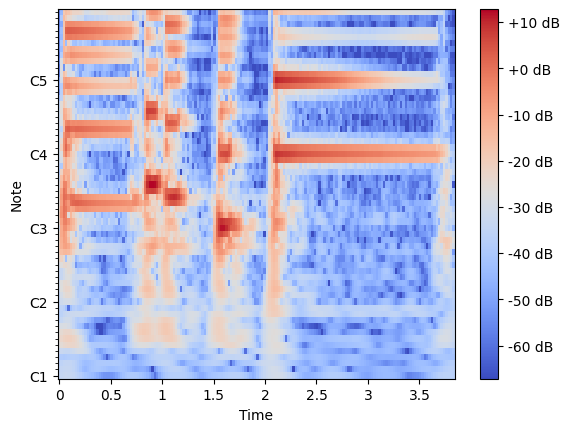

In [5]:
n_octaves = 5  # let's capture 5 octaves starting from C1
bins_per_octave = 12  # let's choose a frequency resolution of 100 cent (= one frequency bin per semitone)
C = np.abs(librosa.cqt(x, sr=fs, n_bins=n_octaves*bins_per_octave , bins_per_octave=bins_per_octave))
C = librosa.amplitude_to_db(C)  # dB magnitude scaling
fig, ax = pl.subplots()
img = librosa.display.specshow(C, sr=fs, x_axis='time', y_axis='cqt_note', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.0f dB")
pl.show()

### CENS (Chroma Energy Normalize) Chroma Features

Let's first check the librosa documentation: https://librosa.org/doc/main/generated/librosa.feature.chroma_cens.html

The most important parameters are 
  - **y** - audio sample vector ($x$)
  - **sr** - sampling rate of the audio signal (in Hz)
  - **hop_length** - see above (STFT)
  - **f_min** - minimum frequency (we can use the default value of 32.70 Hz which corresponds to the note C1)
  - **n_bins** - total number of frequency bins (e.g., for a frequency resolution of one bin per semitone and 4 octaves, this would be 4 * 12 = 48)
  - **bins_per_octave** - Logarithmic frequency resolution (frequency bins per octave, commonly: 12 or 36)
  - **tuning** - Tuning offset (can be used if known tuning frequency of an audio recording deviates from 440 Hz) 
  

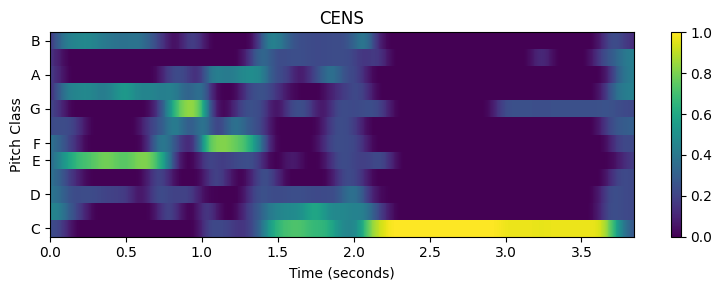

In [16]:
hop_length=128
cens = librosa.feature.chroma_cens(y=x, sr=fs, hop_length=hop_length, fmin=None, tuning=None, n_chroma=12, n_octaves=7, bins_per_octave=36)
t_max = len(x) / fs

pl.figure(figsize=(8,3))
pl.imshow(cens, aspect="auto", interpolation="None", origin="lower", extent=[0, t_max, 0, cens.shape[0]])
# let's create an interpretable pitch axis
pl.yticks([0.5, 2.5, 4.5, 5.5, 7.5, 9.5, 11.5], ['C', 'D', 'E', 'F', 'G', 'A', 'B'])
pl.xlabel('Time (seconds)')
pl.ylabel('Pitch Class')
pl.title('CENS')
pl.colorbar()
pl.tight_layout()
pl.show()

The chroma features give a nice visual summary of the pitch class distribution over time. 

**Note**: this is not a transcription as the pitch classes of the partial frequencies also affect this representation!

### Chord Inversions

Now we'll analyze a new file. It has 4 successive chords
  - C major (root position): C E G
  - C/E (first inversion): E G C
  - C/G (second inversion): G C E
  - C major (root position, one octave higher)
  
The chord sequence is first played using a piano, then repeated using a synthesizer sound.

Here's the pianoroll view:

In [17]:
image_url = "https://github.com/machinelistening/machinelistening.github.io/blob/master/c_maj_inv_2_sounds.png?raw=true"
ipd.display(ipd.Image(url=image_url))

Let's listen to the audio file

In [18]:
fn_wav = 'c_maj_inv_2_sounds.wav'
x, fs = librosa.load(fn_wav)
ipd.display(ipd.Audio(data=x, rate=fs))

Now let's have a look to the CENS Chromagram?

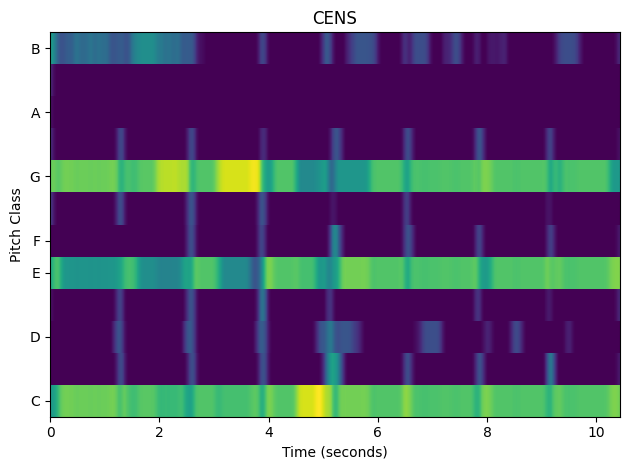

In [19]:
hop_length=128
cens = librosa.feature.chroma_cens(y=x, sr=fs, hop_length=hop_length, fmin=None, tuning=None, n_chroma=12, n_octaves=7, bins_per_octave=36)
t_max = len(x) / fs

pl.figure()
pl.imshow(cens, aspect="auto", interpolation="None", origin="lower", extent=[0, t_max, 0, cens.shape[0]])
# let's create an interpretable pitch axis
pl.yticks([0.5, 2.5, 4.5, 5.5, 7.5, 9.5, 11.5], ['C', 'D', 'E', 'F', 'G', 'A', 'B'])
pl.xlabel('Time (seconds)')
pl.ylabel('Pitch Class')
pl.title('CENS')
pl.tight_layout()
pl.show()

What do you observe?

1) Why is the chromagram pattern not changing for different inversions?
2) Why is the chromagram pattern not changing for different instrument timbres?
3) Can you guess where the "transient" (vertical) structures come frome?

For comparison, let's check the CQT again, here we should see how the fundamental frequency and the harmonics are increasing in frequency along the chord sequence (similar to the piano roll)

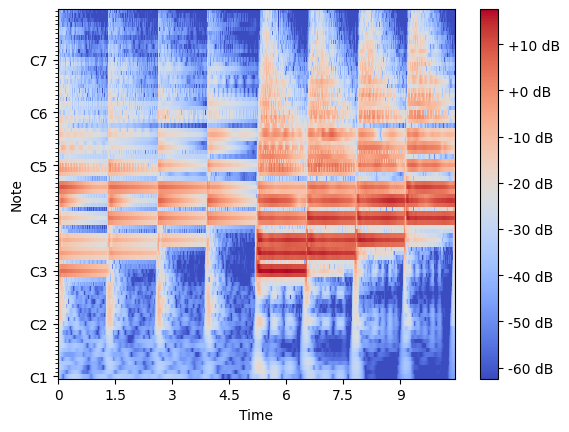

In [20]:
n_octaves = 7  # let's capture 7 octaves starting from C1
bins_per_octave = 12  # let's choose a frequency resolution of 100 cent (= one frequency bin per semitone)
C = np.abs(librosa.cqt(x, sr=fs, n_bins=n_octaves*bins_per_octave , bins_per_octave=bins_per_octave))
C = librosa.amplitude_to_db(C)  # dB magnitude scaling
fig, ax = pl.subplots()
img = librosa.display.specshow(C, sr=fs, x_axis='time', y_axis='cqt_note', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.0f dB")
pl.show()

### Mel-Frequency Cepstral Coefficients (MFCC)

Let's first check the librosa documentation: https://librosa.org/doc/main/generated/librosa.cqt.html

The most important parameters are 
  - **y** - audio sample vector ($x$)
  - **sr** - sampling rate of the audio signal (in Hz)
  - **n_fft** - see above (STFT)
  - **hop_length** - see above (STFT)
  - **n_mfcc** - Number of MFC coefficients  

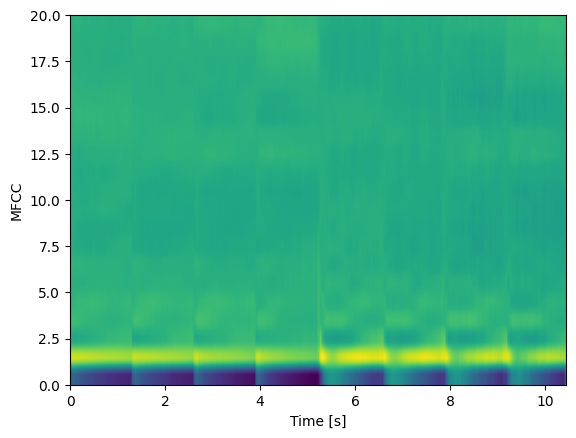

In [21]:
# let's compute and visualize 13 MFCCs
n_mfcc = 20
n_fft = 2048
hop_length = 1024
mf = librosa.feature.mfcc(y=x, sr=fs, S=None, n_mfcc=n_mfcc, dct_type=2, norm='ortho', lifter=0, n_fft=n_fft, hop_length=hop_length)
pl.figure()
pl.imshow(mf, aspect="auto", origin="lower", extent=[0, t_max, 0, mf.shape[0]])
pl.xlabel('Time [s]')
pl.ylabel('MFCC')
pl.show()

We will use the MFCC features in the upcoming seminars as timbre feature for different classification tasks ...

Done :)